# Online Retail Store - Clustering

- It is a transactional data set of an online store based on UK, where all the transactions occurring between 01/12/2010 and 09/12/2011
The steps are broadly:
    - Read and understand the data
    - Clean the data
    - Prepare the data for modelling
    - Modelling
    - Final analysis and recommendations

## Read the data

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt

import sklearn 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
retail = pd.read_csv('Online+Retail.csv',sep=',',encoding='ISO-8859-1', header=0)
retail.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
retail.shape

(541909, 8)

In [4]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## Clean the data

In [5]:
# Print the missing values count
round(100*(retail.isnull().sum()/len(retail.index)),2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [6]:
# Drop rows having missing values
retail = retail.dropna()
retail.shape

(406829, 8)

In [7]:
retail.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


## Prepare the data for Modeling

- R (Recency)    : Number of days since last purchase
- F (Frequency)  : Number of transactions over a year
- M (Monetory)   : Total Amount of Transactions 

Hence final dataframe should have values such as CustID, Recency, Frequency, Monetory for further clustering

In [8]:
# Amount value to calculate Monetory value
retail['Amount'] = retail['UnitPrice']*retail['Quantity']
retail.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [9]:
# get Monetory value for evry customer
monetory = retail.groupby('CustomerID')['Amount'].sum()
monetory = monetory.reset_index()
monetory.head(5)

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [10]:
# get Frequency value for every customer 
frequency = retail.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()
frequency.columns = ['CustomerID', 'Frequency']
frequency.head(5)

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [11]:
# Merge Monetory, Frequency as single dataframe
grouped_df = pd.merge(monetory, frequency, how='inner', on = 'CustomerID')
grouped_df.head(5)

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [12]:
# To calcluate Recency, use the column InvoiceDate - which is an object colum 
# Convert it to Date type 
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], format='%d-%m-%Y %H:%M')
retail.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [13]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
 8   Amount       406829 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.0+ MB


In [14]:
max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [15]:
# Finding the difference of date
retail['diff'] = max_date-retail['InvoiceDate']
retail.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [16]:
# Finding the recent transaction
last_purchase = retail.groupby('CustomerID')['diff'].min()
last_purchase = last_purchase.reset_index()
last_purchase.head(5)

,CustomerID,diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [17]:
# Merge with grouped_df
grouped_df = pd.merge(grouped_df,last_purchase , on='CustomerID', how='inner')
grouped_df.columns =['CustomerID', 'Amount','Frequency','Recency']
grouped_df.head(5)

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [18]:
#Convert receny to days 
grouped_df['Recency'] = grouped_df['Recency'].dt.days
grouped_df.head(5)

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


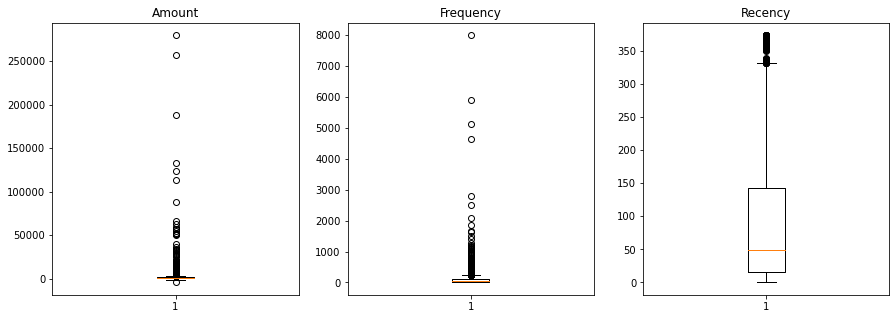

In [19]:
# 1. Outlier treatment 
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.boxplot(grouped_df['Amount'])
plt.title('Amount')
plt.subplot(1,3,2)
plt.boxplot(grouped_df['Frequency'])
plt.title('Frequency')
plt.subplot(1,3,3)
plt.boxplot(grouped_df['Recency'])
plt.title('Recency')
plt.show()

- Here I could see, `Amount` has outliers but cannot remove this, as these data can be put into a cluster seperately
- For `Frequency`, there are outliers can be put into another cluster 
- Looking into `Recency`, there are lot of people who has 300 days - People who has not done any transaction in past 300 days - Present as a seperate cluster 
- Hence, outlier removal depends completely on the business requirement

In [20]:
# Removing Outliers for Amount using IQR range
Q1 = grouped_df.Amount.quantile(0.05)
Q3 = grouped_df.Amount.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.Amount >= Q1 - 1.5*IQR) & (grouped_df.Amount <= Q3 + 1.5*IQR)]

# Removing Outliers for Frequency using IQR range
Q1 = grouped_df.Frequency.quantile(0.05)
Q3 = grouped_df.Frequency.quantile(0.95)
IQR = Q3 - Q1 
grouped_df = grouped_df[(grouped_df.Frequency >= Q1 - 1.5*IQR) & (grouped_df.Frequency <= Q3 + 1.5*IQR)]

# Removing Outliers for Recency using IQR range
Q1 = grouped_df.Recency.quantile(0.05)
Q3 = grouped_df.Recency.quantile(0.95)
IQR = Q3 - Q1 
grouped_df = grouped_df[(grouped_df.Recency >= Q1 - 1.5*IQR) & (grouped_df.Recency <= Q3 + 1.5*IQR)]


In [21]:
# 2. Rescaling 
# Two Types - Standardization 2. Normalization(Min-Max Scaler)
rfm_df = grouped_df[['Amount','Frequency', 'Recency']]

scaler = StandardScaler()

rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

In [22]:
# Rfm is converted to standard scaler 
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head(5)

,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


 - Now all the standardization and Outlier detection is done

### Hopkins Statistics:
The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

- If the value is between {0.01, ...,0.3}, the data is regularly spaced.

- If the value is around 0.5, it is random.

- If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

- We can determine the hopkin's statistic for our data to determine Cluster Tendency

In [23]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [24]:
# Check for rfm_df_sclaed
hopkins(rfm_df_scaled)

0.9496944077311908

- As seen, Hopkin Statistics value is `0.95`

## Modeling 

In [25]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [26]:
len(kmeans.labels_)

4293

## Finding Optimal number of Customers

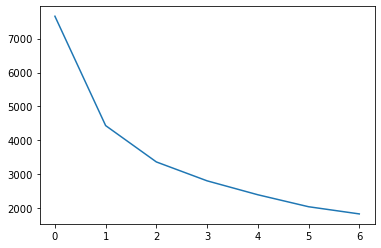

In [27]:
# elbow curve/ SSD 
ssd = []
cluster_range = [2,3,4,5,6,7,8]
for n in cluster_range:
    kmeans = KMeans(n_clusters=n, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)

plt.plot(ssd)
plt.show()

In [28]:
# Silhouette Analysis 
cluster_range = [2,3,4,5,6,7,8]

for n in cluster_range:
    
    kmeans = KMeans(n_clusters=n, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(n, silhouette_avg))

For n_clusters=2, the silhouette score is 0.541842117113117
For n_clusters=3, the silhouette score is 0.5084896296141937
For n_clusters=4, the silhouette score is 0.48166097487908327
For n_clusters=5, the silhouette score is 0.4662700564189704
For n_clusters=6, the silhouette score is 0.41780258108181684
For n_clusters=7, the silhouette score is 0.4153706969047319
For n_clusters=8, the silhouette score is 0.40992299382906633


In [29]:
# final model chosen is with k= 3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [30]:
kmeans.labels_

array([2, 1, 0, ..., 2, 0, 0])

In [31]:
# assign the label - ClusterID
grouped_df['ClusterID'] = kmeans.labels_
grouped_df.head(5)

,CustomerID,Amount,Frequency,Recency,ClusterID
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,2


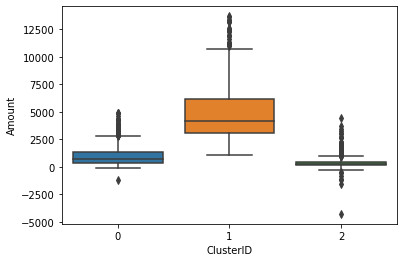

In [32]:
# Amount
sns.boxplot(x='ClusterID', y= 'Amount', data=grouped_df)
plt.show()

- As seen, Cluster 0 represents customers who spend more amount on the platform

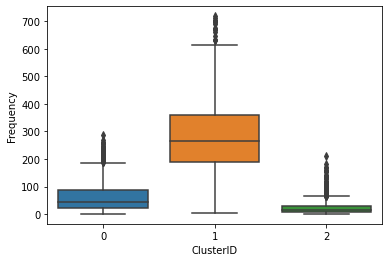

In [33]:
# Frequency
sns.boxplot(x='ClusterID', y= 'Frequency', data=grouped_df)
plt.show()

- Here, Cluster 0 reresents customers who has purchased more frequently

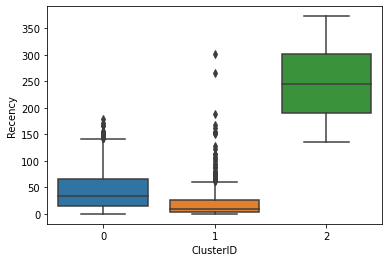

In [34]:
# Recency
sns.boxplot(x='ClusterID', y= 'Recency', data=grouped_df)
plt.show()

- Cluster 0 represents customers who has bought from online store recently 

It is clearly visible that Cluster 0 focused on customers who are more valuable to online store. In contrast Cluster 2 focused on customer who are least valuable to online store

## Hierarchical Clustering

In [35]:
rfm_df_scaled.head(5)

,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


In [36]:
grouped_df.head()

,CustomerID,Amount,Frequency,Recency,ClusterID
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,2


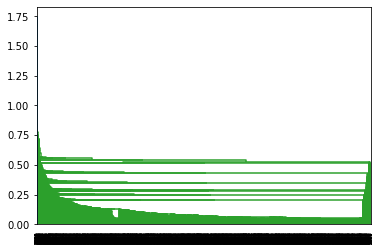

In [38]:
# single linkage 
mergings = linkage(rfm_df_scaled, method='single',metric='euclidean')
dendrogram(mergings)
plt.show()

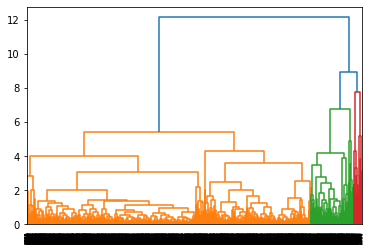

In [39]:
 # complete linkage
mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [40]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 0, ..., 0, 0, 0])

In [41]:
# assign cluster labels
grouped_df['cluster_labels'] = cluster_labels
grouped_df.head()

,CustomerID,Amount,Frequency,Recency,ClusterID,cluster_labels
0,12346.0,0.00,2,325,2,0
1,12347.0,4310.00,182,1,1,1
2,12348.0,1797.24,31,74,0,0
3,12349.0,1757.55,73,18,0,0
4,12350.0,334.40,17,309,2,0


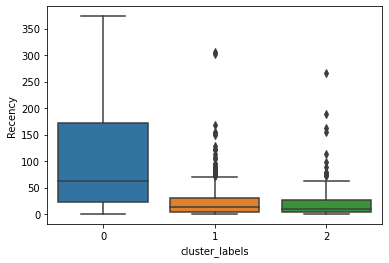

In [43]:
# plots
sns.boxplot(x='cluster_labels', y='Recency', data=grouped_df)

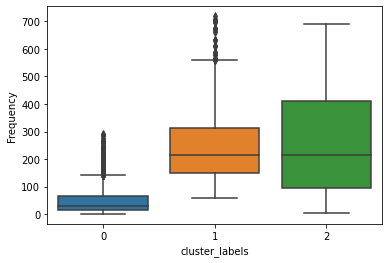

In [44]:
# plots
sns.boxplot(x='cluster_labels', y='Frequency', data=grouped_df)

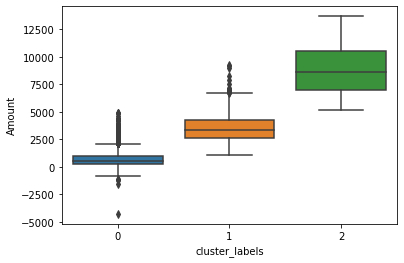

In [45]:
# plots
sns.boxplot(x='cluster_labels', y='Amount', data=grouped_df)